In [2]:
import random

import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader

from loc2vec.dataset import TilesDataset
from loc2vec.model import Loc2VecModel, SoftmaxTripletLoss, Loc2VecTripletLoss
from loc2vec.train import train
from loc2vec.embeddings import log_embeddings_to_tensorboard

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
from loc2vec.memmap_tiles_dataset import MemmapTilesDataset

dataset = MemmapTilesDataset("../loc2vec/tiles/dataset-zhytomyr/metadata.csv", "../loc2vec/tiles/dataset-zhytomyr/zhytomyr.npy", pos_radius=1, neg_radius_min=40, transform=T.Compose([
    # T.ToTensor(),
    T.Normalize([0.8107, 0.8611, 0.7814, 0.5, 0.5, 0.5],
                [0.1215, 0.0828, 0.1320, 0.5, 0.5, 0.5])
]))

In [4]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, prefetch_factor=4, persistent_workers=True)

torch.Size([32, 6, 128, 128])


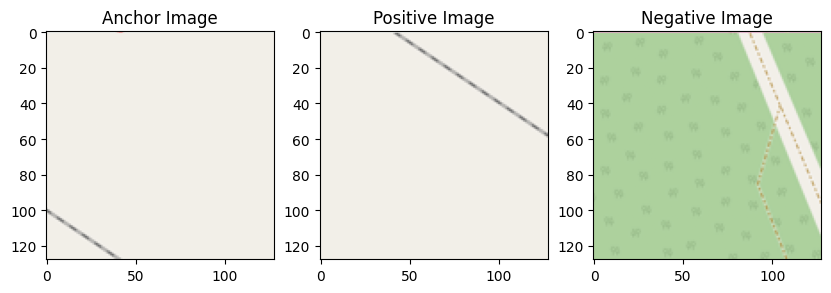

In [5]:
image = next(iter(train_loader))

denormalize = T.Normalize(
    mean=[-0.8107/0.1215, -0.8611/0.0828, -0.7814/0.1320],
    std=[1/0.1215, 1/0.0828, 1/0.1320]
)

print(image['anchor_image'].shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(denormalize(image['anchor_image'][0][:3]).numpy().transpose(1, 2, 0))
plt.title("Anchor Image")

plt.subplot(1, 3, 2)
plt.imshow(denormalize(image['pos_image'][0][:3]).numpy().transpose(1, 2, 0))
plt.title("Positive Image")

plt.subplot(1, 3, 3)
plt.imshow(denormalize(image['neg_image'][0][:3]).numpy().transpose(1, 2, 0))
plt.title("Negative Image")

plt.show()

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = Loc2VecModel(input_channels=6, embedding_dim=16, dropout_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = Loc2VecTripletLoss()

sample = random.choice(dataset)

print(f"Input shape: {sample['anchor_image'].shape}")
print(f"Training on device: {device}")

Input shape: torch.Size([6, 128, 128])
Training on device: mps


In [18]:
# from loc2vec.embeddings import log_embeddings_to_tensorboard
# import torch

# model.to(device)
# model.load_state_dict(torch.load("loc2vec_model_epoch_2.pth"))

# log_embeddings_to_tensorboard(model, train_loader, device=device, log_dir="logs/embeddings", max_samples=16000)

In [9]:
# iterate over the files "./loc2vec_model_epoch_*.pth" and load them into the model
from pathlib import Path

evaluation_dataloader = DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=1, prefetch_factor=4, persistent_workers=True
)

In [ ]:


for path in Path(".").glob("loc2vec_model_epoch_*.pth"):
    logs_dirname = path.name.split(".")[0]
    print(f"Loading model from {path}")
    model.load_state_dict(torch.load(path))
    model.to(device)
    log_embeddings_to_tensorboard(model, evaluation_dataloader, device=device, log_dir=f"logs/embeddings/{logs_dirname}", max_samples=16000)



Loading model from loc2vec_model_epoch_5.pth
Starting embedding extraction, max_samples=16000
Embeddings logged successfully!
Loading model from loc2vec_model_epoch_4.pth
Starting embedding extraction, max_samples=16000
Embeddings logged successfully!
Loading model from loc2vec_model_epoch_3.pth
Starting embedding extraction, max_samples=16000
Embeddings logged successfully!
Loading model from loc2vec_model_epoch_2.pth
Starting embedding extraction, max_samples=16000
Embeddings logged successfully!
Loading model from loc2vec_model_epoch_1.pth
Starting embedding extraction, max_samples=16000
Embeddings logged successfully!


In [11]:
from loc2vec.train import evaluate

eval_loss_history = []

for epoch in range(5):

    # torch.load(model.state_dict(), f"loc2vec_model_epoch_{epoch}.pth")
    model.load_state_dict(torch.load(f"loc2vec_model_epoch_{epoch + 1}.pth"))

    model.to(device)

    # Evaluate the model
    loss = evaluate(model, evaluation_dataloader, loss_fn, device=device)
    eval_loss_history.append(loss)

    

Evaluating: 100%|██████████| 710/710 [00:14<00:00, 48.67it/s]


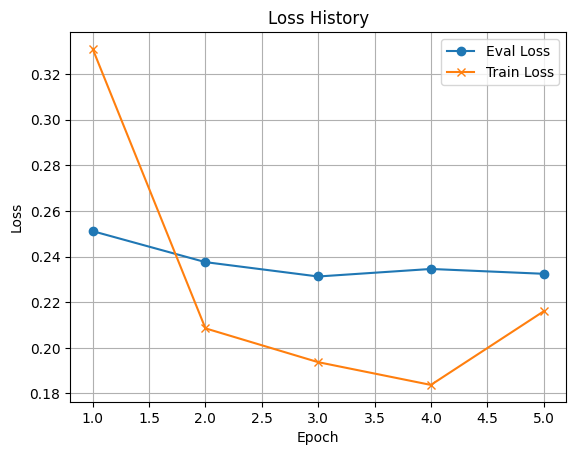

In [ ]:
import matplotlib.pyplot as plt

train_loss = [[0.0004967434406280517, 0.00011774394661188126, 0.0001189306527376175, 0.00013601717352867127, 0.00015542593598365784, 0.00016922712326049804, 9.997086226940154e-05, 0.00014116810262203216, 9.40166786313057e-05, 0.0001257065236568451], [0.0001161084845662117, 0.00013652731478214263, 8.334498107433319e-05, 0.00011040821671485901, 8.801722526550293e-05, 0.00013065192103385925, 0.00011815959215164184, 8.315534889698029e-05, 6.272971630096436e-05, 0.00011361077427864075], [8.746276795864105e-05, 0.0001006234735250473, 7.351501286029816e-05, 0.00010177598893642425, 0.00010448627173900604, 0.0001107976883649826, 0.00011027229577302932, 6.93942829966545e-05, 0.00010213878750801086, 0.00010814812779426575], [0.00010400091111660003, 9.625211358070373e-05, 7.661318778991699e-05, 9.186173975467682e-05, 6.563545763492584e-05, 9.484891593456269e-05, 9.87890511751175e-05, 0.00010976343601942063, 8.800544589757919e-05, 9.297725558280945e-05], [0.0001360076367855072, 7.439516484737396e-05, 0.0001246950477361679, 8.781959116458893e-05, 0.00010975992679595947, 8.187055587768554e-05, 6.764896214008332e-05, 0.0001637173891067505, 0.00012332022935152053, 0.00011071304976940155]]

train_loss_hisotyr = [(sum(epoch_losses) * 2000 / len(epoch_losses)) for epoch_losses in train_loss]

plt.plot(range(1, len(eval_loss_history) + 1), eval_loss_history, marker='o', label='Eval Loss')
plt.plot(range(1, len(train_loss_hisotyr) + 1), train_loss_hisotyr, marker='x', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid()
plt.show()
